### SplitGPM

A cleaned up implementation of SplitGMP

The input to the GP X should be augmented with two extra columns with indices indexing cell and gene ids. This differs from the original implementation where we pass these indices as seperate arguments to the constructor.

All optimization in this notebook is done using gradient based optimization. W1 and W2 correspoind to Phi and Lambda, the cell cluster assignments and gene cluster assignments, respectively.

There are closed form updates available-- and if you wanted you could interleave optimization of the inducing points and variational parameters with updates

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.stats import multivariate_normal


import gpflow
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf

import pickle

from splitgpm import SplitGPM, normalize
import gpflow.training.monitor as mon
import os
import seaborn as sns
import matplotlib.pyplot as plt

### Set some hyperparameters

Set K1, and K2 to what you want. C, G, and T come from your data so get those from the data when you load it.

In [3]:
G = 200  # Number of genes (for simulation)
C = 50  # number of cells
T = 10  # number of timepoints

K1 = 2  # cell clusters
K2 = 10  # gene clusters

### Generate some data

#### How to set up the data

The first columns of X are whatever your inputs are. Each row of X is a (cell-line, gene) pair. For us it was time, but the inputs can be anything. It also supports higher dimensional input.

The last two columns of X are an integer cell index and a gene index, which should identify the cell and gene

X is and [100000, 3] matrix

Y is [100000, 1] is the (normalized) gene expression

In [4]:
X = np.linspace(0, 1, T)

#random frequency and phase for each cluster
base_freqs = 2*np.pi + 0.3*(np.random.rand(K1 * K2)-.5)
base_phases = 2*np.pi*np.random.rand(K1 * K2)
base_amplitudes = 1 + np.random.rand(K1 * K2)

def template_function(x, f, p, amp):
    return np.sin(f * x + p) * amp

# means = np.vstack([(np.sin(f*X+p).T * amp) for f,p, amp in zip(base_freqs,base_phases, base_amplitudes)])
functions = {}
func_params = {}
for k1 in range(K1):
    for k2 in range(K2):
        k = k1 * K2 + k2
        
        f = base_freqs[k]
        p = base_phases[k]
        amp = base_amplitudes[k]
        
        functions[(k1, k2)] = lambda z: template_function(z, f, p, amp)
        func_params[(k1, k2)] = (f, p, amp)

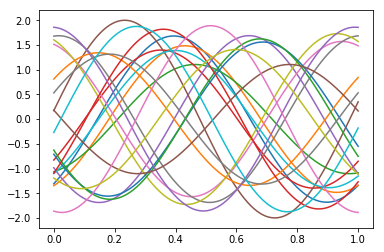

In [5]:
for k1 in range(K1):
    for k2 in range(K2):
        plt.plot(np.linspace(0, 1, 100), template_function(np.linspace(0, 1, 100), *func_params[(k1, k2)]))

In [6]:
cell_assignments = np.random.choice(K1, C * T)
gene_assignments = np.random.choice(K2, G)

In [7]:
N = C * T # Total number of cells

W1_true = np.zeros((C * T, K1))
for k in range(K1):
    W1_true[cell_assignments==k, k] = 1
    
W2_true = np.zeros((G, K2))
for g in range(K2):
    W2_true[gene_assignments==g, g] = 1

In [8]:
cell_idx = np.tile(np.arange(C * T).reshape([C, 1, T]), [1, G, 1]).flatten()
gene_idx = np.tile(np.arange(G)[None, :, None], [C, 1, 10]).flatten()

timepoints = np.linspace(0, 1, T)
timepoints = np.tile(timepoints, [C, G, 1]).flatten()
X = timepoints + np.random.normal(size=timepoints.size) * 0.1
X = np.stack([X, cell_idx, gene_idx]).T.astype(np.float64)

In [9]:
Y = []
for x in X:
    time, cell, gene = x[0], int(x[1]), int(x[2])
    k1 = cell_assignments[cell]
    k2 = gene_assignments[gene]
    
    y = template_function(time, *func_params[(k1, k2)])
    y += np.random.normal() * 0.1
    Y.append(y)
Y = np.array(Y)[:, None]

### Initialize the model

We need to initialize W1 and W2, which are [N, K1], [G, K2] respectively and hold the estimated probability that a cell belongs to a given cell cluster, or a gene belongs to a give gene cluster repsectively. Here they are initialized randomly, but a better choice can probably be made.

When we call the constructor we pass the following arguments
- X
- Y
- logW1 the log assignment weights for cells to cell clusters (add a small constant to prevent log(0)) [N, K1]
- logW2 thel log assignment probability for genes to gene clusters [G, K2]
- a gplfow multioutput kernel object, this controls how the functions we estimate behave. We use and RBF kernel here which generates smooth function
- a gpflow multioutput feature object, this holds the inducing points-- a set of points that we are going to summarize our data at
- minibatch size: if we have a lot of data we will need to subsample to make it tractable
- name: a name for the model to keep things neat with tensorflow

In [10]:
from splitgpm import SplitGPM

In [11]:
def normalize(X):
    return X / X.sum(1)[:, None]

In [12]:
gpflow.reset_default_graph_and_session()
name = 'test'
minibatch_size = 500

W1_init = normalize(np.random.random(size=(N, K1)))
W2_init = normalize(np.random.random(size=(G, K2)))


with gpflow.defer_build():
    kernel = mk.SharedIndependentMok(gpflow.kernels.RBF(1, active_dims=[0]), K1 * K2)
    Z = np.linspace(0, 1, T)[:, None].astype(np.float64)
    feature = gpflow.features.InducingPoints(Z)
    feature = mf.SharedIndependentMof(feature)

    model = SplitGPM(X, Y,
                   np.log(W1_init + 1e-5), np.log(W2_init + 1e-5),
                   kernel, gpflow.likelihoods.Gaussian(),
                   feat=feature,
                   minibatch_size=minibatch_size,
                   name=name)
model.compile()

W0806 19:34:48.614732 4425582016 deprecation.py:323] From /Users/karltayeb/anaconda3/lib/python3.7/site-packages/gpflow/params/dataholders.py:223: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [13]:
model

,class,prior,transform,trainable,shape,fixed_shape,value
test/W1,Parameter,None,(none),False,"(500, 2)",True,"[[-0.5602136475989647, -0.846454641354898], [-..."
test/W1_prior,Parameter,None,(none),False,"(2,)",True,"[0.5, 0.5]"
test/W2,Parameter,None,(none),False,"(200, 10)",True,"[[-2.446741194438657, -2.128257820125743, -2.4..."
test/W2_prior,Parameter,None,(none),False,"(10,)",True,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ..."
test/feature/feat/Z,Parameter,None,(none),True,"(10, 1)",True,"[[0.0], [0.1111111111111111], [0.2222222222222..."
test/kern/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
test/kern/kern/variance,Parameter,None,+ve,True,(),True,1.0
test/likelihood/variance,Parameter,None,+ve,True,(),True,1.0
test/q_mu,Parameter,None,(none),True,"(10, 20)",True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
test/q_sqrt,Parameter,None,LoTri->vec,True,"(20, 10, 10)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


### What parts of the model do you want to train?

In [15]:
model.W1.set_trainable(True)  # learn cell assignments
model.W2.set_trainable(True)  # learn gene assignments
model.feature.set_trainable(True)  # move inducing points
model.kern.set_trainable(True)  # learn kernel parameters
model.likelihood.set_trainable(True)  # lear likelihood parameters

### Train the model

Note that all we are doing here is gradient based optimization of the objective. There are closed form updates for a lot of the parameters we are estimating here if we stick with Gaussian noise. But gradient based optimization seems to learn decent representations and the closed form updates in this implementation arent tested yet.

In [16]:
adam = gpflow.train.AdamOptimizer(0.005)
adam.minimize(model, maxiter=10000)

W0806 19:34:53.754133 4425582016 deprecation.py:323] From /Users/karltayeb/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_grad.py:425: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0806 19:34:54.251120 4425582016 deprecation.py:506] From /Users/karltayeb/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
Xnew = np.linspace(0, 1, 100)[:, None]
mu, var = model.predict_f(Xnew)

In [18]:
mu.shape

(100, 20)

### Make a plot

Here we can plot the trajectories learned for each cluster. Notice here that it didnt actually learn trajectories that look very much like the sinusoidal functions used to generate the data.

We are prone to these sorts of local optima when we do not know how observations in different parts of the domain are related to one another-- if we had observations throughout the input space that we know belong to the same cluster (this information would be encoded in the index columns of X)

Notice also that it learned a solution with an empty gene cluster-- we can escape these types of local optima by resetting those clusters until something sticks to it

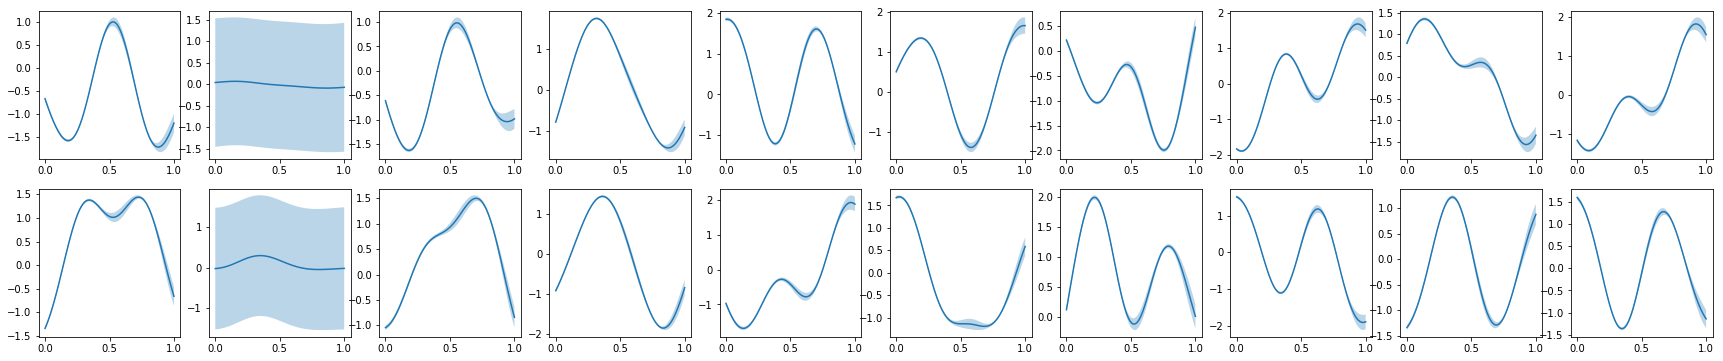

In [21]:
fig, ax = plt.subplots(K1, K2, figsize=(K2 * 3, K1 * 3))

mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T

a1 = model.W1.value.argmax(1)[X[:, 1].astype(int)]
a2 = model.W2.value.argmax(1)[X[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[k, l].plot(Xnew, mu[:, l, k])
        ax[k, l].fill_between(
            Xnew.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)

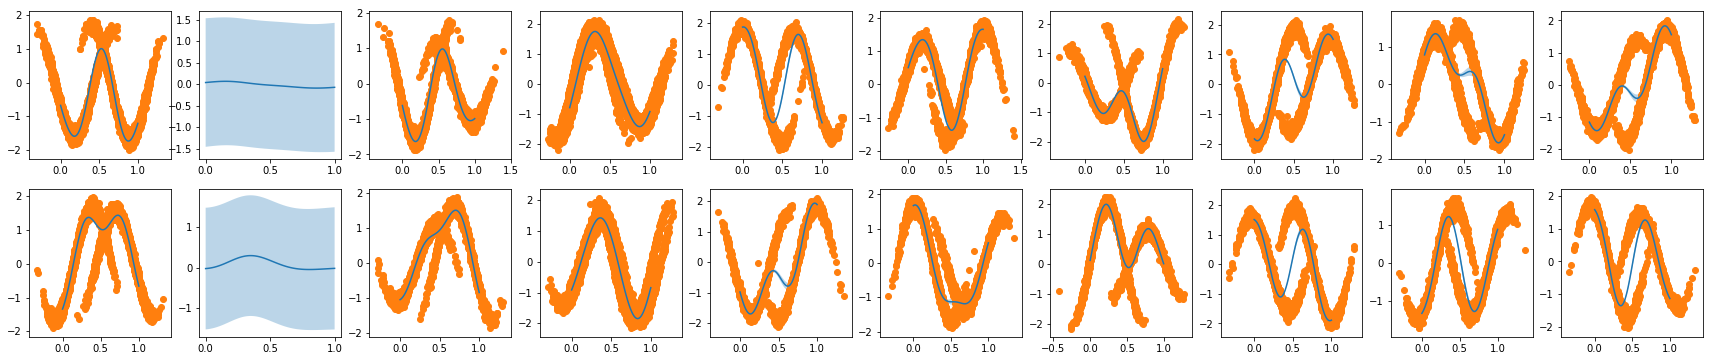

In [19]:
fig, ax = plt.subplots(K1, K2, figsize=(K2 * 3, K1 * 3))

mu = mu.T.reshape((K1, K2, -1)).T
var = var.T.reshape((K1, K2, -1)).T

a1 = model.W1.value.argmax(1)[X[:, 1].astype(int)]
a2 = model.W2.value.argmax(1)[X[:, 2].astype(int)]
for k in range(K1):
    for l in range(K2):
        ax[k, l].plot(Xnew, mu[:, l, k])
        ax[k, l].fill_between(
            Xnew.flatten(),
            mu[:, l, k] - np.sqrt(var[:, l, k])*2,
            mu[:, l, k] + np.sqrt(var[:, l, k])*2, alpha=0.3)
        
        assigned_points = np.logical_and(a1 == k, a2 == l)
        ax[k, l].scatter(X[assigned_points, 0], Y[assigned_points, 0])